In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
tainan_2021_23 = pd.read_csv('/Users/lee/Documents/pm2019~2022_data/tainan_2021_23_w.csv')


In [3]:
tainan_2021_23['date'] = pd.to_datetime(tainan_2021_23['date']).dt.strftime('%Y-%m-%d %H:%M:%S')

In [4]:
tainan_2021_23

,date,CH4,CO,NO,NO2,O3,PM10,PM2.5,SO2
0,2021-01-01 00:00:00,2.00,0.38,1.7,18.5,9.8,45.0,32.0,2.2
1,2021-01-01 01:00:00,1.99,0.39,1.5,18.0,9.2,33.0,27.0,2.2
2,2021-01-01 02:00:00,2.00,0.39,1.2,17.3,8.7,35.0,31.0,2.2
3,2021-01-01 03:00:00,2.00,0.38,1.2,17.3,8.4,39.0,30.0,2.3
4,2021-01-01 04:00:00,2.00,0.37,1.2,16.1,8.3,35.0,30.0,2.3
...,...,...,...,...,...,...,...,...,...
26275,2023-12-31 19:00:00,2.17,0.48,0.4,12.4,50.0,87.0,42.0,1.8
26276,2023-12-31 20:00:00,2.19,0.55,0.3,12.1,45.5,102.0,61.0,1.5
26277,2023-12-31 21:00:00,2.21,0.57,0.4,12.6,40.8,92.0,63.0,1.8
26278,2023-12-31 22:00:00,2.22,0.58,0.3,12.9,39.2,98.0,61.0,2.0


In [5]:
# 缺失值
print(tainan_2021_23.isnull().sum())
tainan_2021_23 = tainan_2021_23.fillna(method='ffill')

date       0
CH4      556
CO       503
NO       719
NO2      719
O3       546
PM10     708
PM2.5    395
SO2      506
dtype: int64


/var/folders/qy/kj449rc16jg1cmdlz7t99h5m0000gn/T/ipykernel_53195/4174106043.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tainan_2021_23 = tainan_2021_23.fillna(method='ffill')


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
numeric_columns = tainan_2021_23.select_dtypes(include=['float64', 'int64']).columns
scaled_data = scaler.fit_transform(tainan_2021_23[numeric_columns])

# scaled numeric data
scaled_tainan_2021_23 = pd.DataFrame(
    scaled_data, 
    index=tainan_2021_23.index, 
    columns=numeric_columns
)

# Add non-numeric 
non_numeric_columns = tainan_2021_23.select_dtypes(exclude=['float64', 'int64']).columns
for col in non_numeric_columns:
    scaled_tainan_2021_23[col] = tainan_2021_23[col]

In [123]:
scaled_tainan_2021_23

,CH4,CO,NO,NO2,O3,PM10,PM2.5,SO2,date
0,0.479319,0.213483,0.019653,0.304276,0.089335,0.182186,0.246154,0.056701,2021-01-01 00:00:00
1,0.476886,0.219101,0.017341,0.296053,0.083865,0.133603,0.207692,0.056701,2021-01-01 01:00:00
2,0.479319,0.219101,0.013873,0.284539,0.079307,0.141700,0.238462,0.056701,2021-01-01 02:00:00
3,0.479319,0.213483,0.013873,0.284539,0.076572,0.157895,0.230769,0.059278,2021-01-01 03:00:00
4,0.479319,0.207865,0.013873,0.264803,0.075661,0.141700,0.230769,0.059278,2021-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...
26275,0.520681,0.269663,0.004624,0.203947,0.455789,0.352227,0.323077,0.046392,2023-12-31 19:00:00
26276,0.525547,0.308989,0.003468,0.199013,0.414768,0.412955,0.469231,0.038660,2023-12-31 20:00:00
26277,0.530414,0.320225,0.004624,0.207237,0.371923,0.372470,0.484615,0.046392,2023-12-31 21:00:00
26278,0.532847,0.325843,0.003468,0.212171,0.357338,0.396761,0.469231,0.051546,2023-12-31 22:00:00


In [19]:
tainan_endog = scaled_tainan_2021_23[['PM2.5']]
tainan_exog = scaled_tainan_2021_23[['O3', 'SO2', 'CH4', 'NO', 'PM10']]

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 計算 VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                       for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

# 使用外生變數計算 VIF
vif_values = calculate_vif(tainan_exog)
print("\nVariance Inflation Factors:")
print(vif_values)


Variance Inflation Factors:
  Variable       VIF
2      CH4  6.693976
4     PM10  4.670586
0       O3  4.307633
1      SO2  3.135526
3       NO  1.573875


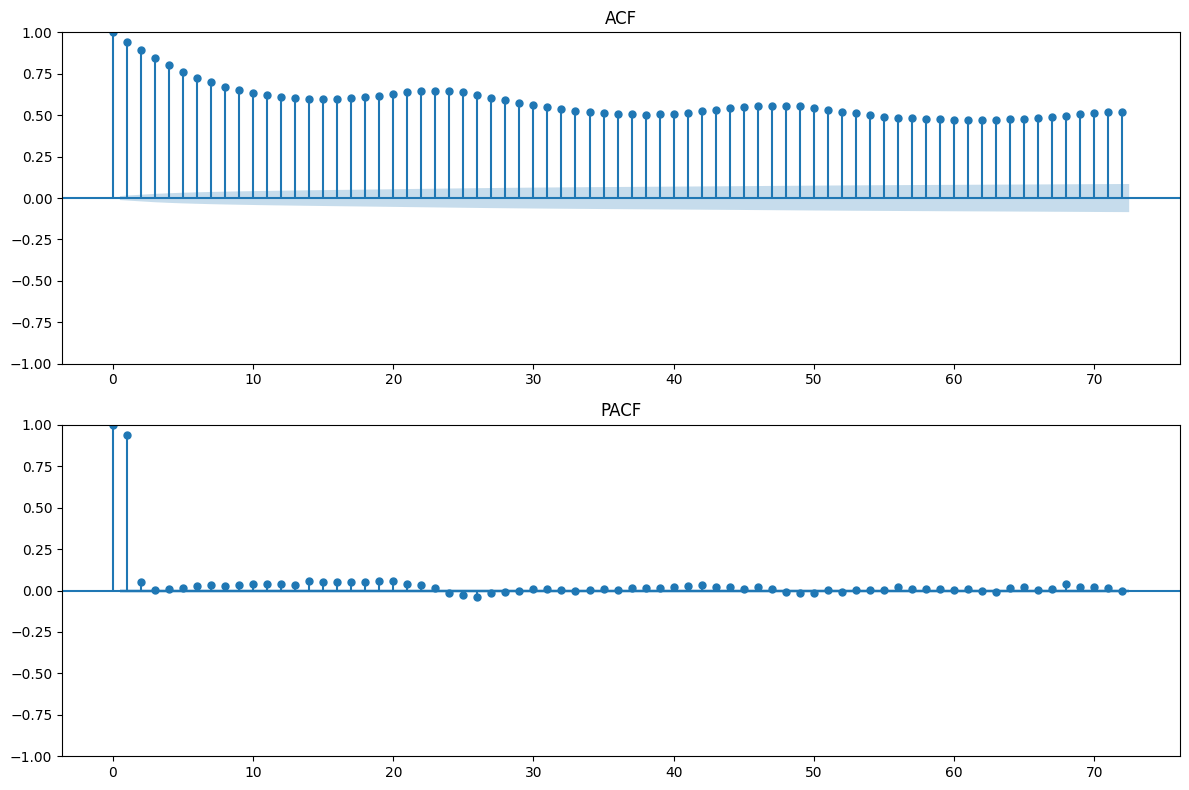

In [ ]:


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF
plot_acf(tainan_endog['PM2.5'], lags=72, ax=ax1)  # 觀察3天的延遲
ax1.set_title('ACF')

# PACF
plot_pacf(tainan_endog['PM2.5'], lags=72, ax=ax2)
ax2.set_title('PACF')

plt.tight_layout()
plt.show()

In [214]:

train_size = int(len(tainan_endog) * 0.8)
train_tainan_endog = tainan_endog[:train_size]
test_tainan_endog = tainan_endog[train_size:]
train_tainan_exog = tainan_exog[:train_size]
test_tainan_exog = tainan_exog[train_size:]

model = SARIMAX(train_tainan_endog, 
                exog=train_tainan_exog,
                order=(2,1,1),            
                seasonal_order=(1,1,1,24))

model_result = model.fit(disp=False)


print(model_result.summary())

/Users/lee/miniforge3/envs/ML_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              PM2.5   No. Observations:                21024
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 24)   Log Likelihood               43803.549
Date:                            Mon, 06 Jan 2025   AIC                         -87585.097
Time:                                    21:11:38   BIC                         -87497.623
Sample:                                         0   HQIC                        -87556.546
                                          - 21024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
O3             0.0134      0.004      3.489      0.000       0.006       0.021
SO2            0.1839      0.004   

In [26]:
forecast

21024    0.078339
21025    0.114891
21026    0.085870
21027    0.116358
21028    0.102511
           ...   
26275    0.254393
26276    0.293341
26277    0.273631
26278    0.292916
26279    0.297441
Name: predicted_mean, Length: 5256, dtype: float64

In [215]:
model_result.forecast(steps=len(test_tainan_exog), exog=test_tainan_exog[['O3', 'SO2', 'CH4', 'NO', 'PM10']])

21024    0.078339
21025    0.114891
21026    0.085870
21027    0.116358
21028    0.102511
           ...   
26275    0.254393
26276    0.293341
26277    0.273631
26278    0.292916
26279    0.297441
Name: predicted_mean, Length: 5256, dtype: float64

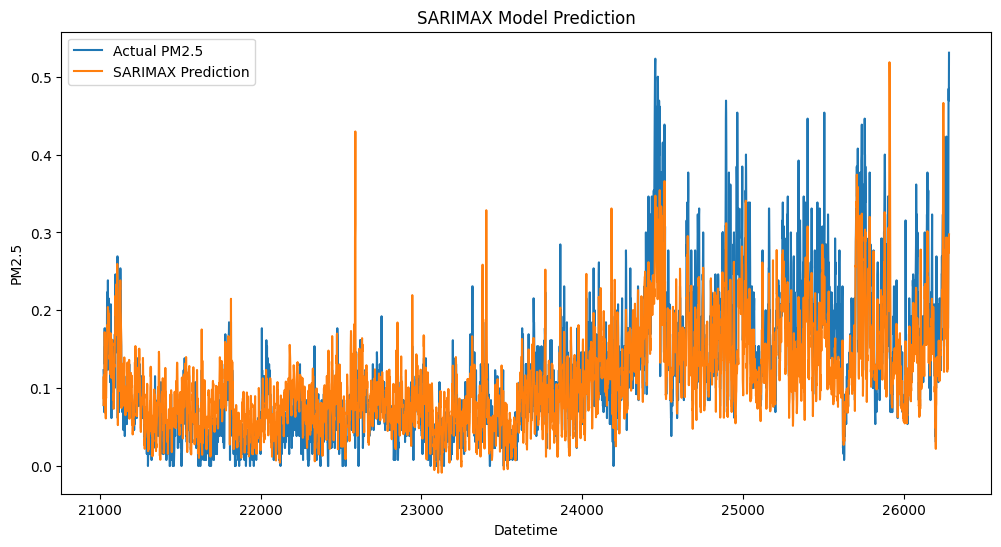

In [230]:
# 進行預測
forecast = model_result.forecast(steps=len(test_tainan_exog), exog=test_tainan_exog[['O3', 'SO2', 'CH4', 'NO', 'PM10']])

# 將預測結果與實際值進行比較
plt.figure(figsize=(12,6))
plt.plot(test_tainan_endog.index, test_tainan_endog['PM2.5'], label='Actual PM2.5')
plt.plot(test_tainan_endog.index, forecast, label='SARIMAX Prediction')
plt.title('SARIMAX Model Prediction')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


In [ ]:
# 訓練集殘差
train_pred = model_result.fittedvalues
train_tainan_residuals = train_tainan_endog['PM2.5'] - train_pred

In [32]:
# test集殘差
test_tainan_residuals = test_tainan_endog['PM2.5'] - forecast
test_tainan_residuals

21024    0.044738
21025    0.000493
21026   -0.008947
21027   -0.031742
21028   -0.033280
           ...   
26275    0.068684
26276    0.175890
26277    0.210985
26278    0.176315
26279    0.233328
Length: 5256, dtype: float64

In [96]:
# 使用縮放後的資料
train_scaled_LSTM = scaled_tainan_2021_23.iloc[:train_size]
test_scaled_LSTM = scaled_tainan_2021_23.iloc[train_size:]

# 準備 LSTM 的輸入和輸出
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 使用殘差作為目標變數，特徵變數為縮放後的數據
X_train, y_train = create_dataset(
    train_scaled_LSTM[['O3', 'SO2', 'CH4', 'NO', 'PM10']].values,
    train_tainan_residuals.values,
    time_steps=1
)

X_test, y_test = create_dataset(
    test_scaled_LSTM[['O3', 'SO2', 'CH4', 'NO', 'PM10']].values,
    test_tainan_residuals.values,
    time_steps=1
)


In [123]:
# 建立 LSTM 模型
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# 訓練模型
model_lstm.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)


Epoch 1/50
292/292 - 1s - 4ms/step - loss: 9.0969e-04 - val_loss: 0.0023
Epoch 2/50
292/292 - 0s - 1ms/step - loss: 9.0647e-04 - val_loss: 0.0023
Epoch 3/50
292/292 - 0s - 1ms/step - loss: 9.0554e-04 - val_loss: 0.0023
Epoch 4/50
292/292 - 0s - 1ms/step - loss: 9.0470e-04 - val_loss: 0.0023
Epoch 5/50
292/292 - 0s - 1ms/step - loss: 9.0395e-04 - val_loss: 0.0023
Epoch 6/50
292/292 - 0s - 1ms/step - loss: 9.0328e-04 - val_loss: 0.0023
Epoch 7/50
292/292 - 0s - 1ms/step - loss: 9.0267e-04 - val_loss: 0.0023
Epoch 8/50
292/292 - 0s - 1ms/step - loss: 9.0212e-04 - val_loss: 0.0023
Epoch 9/50
292/292 - 0s - 1ms/step - loss: 9.0161e-04 - val_loss: 0.0023
Epoch 10/50
292/292 - 0s - 1ms/step - loss: 9.0113e-04 - val_loss: 0.0023
Epoch 11/50
292/292 - 0s - 1ms/step - loss: 9.0070e-04 - val_loss: 0.0023
Epoch 12/50
292/292 - 0s - 1ms/step - loss: 9.0029e-04 - val_loss: 0.0023
Epoch 13/50
292/292 - 0s - 1ms/step - loss: 8.9990e-04 - val_loss: 0.0023
Epoch 14/50
292/292 - 0s - 951us/step - loss: 8

In [128]:
# 預測殘差
lstm_pred = model_lstm.predict(X_test)

# 還原縮放
lstm_pred_rescaled = lstm_pred  # 如果之前未對殘差進行縮放，則無需反向縮放


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step


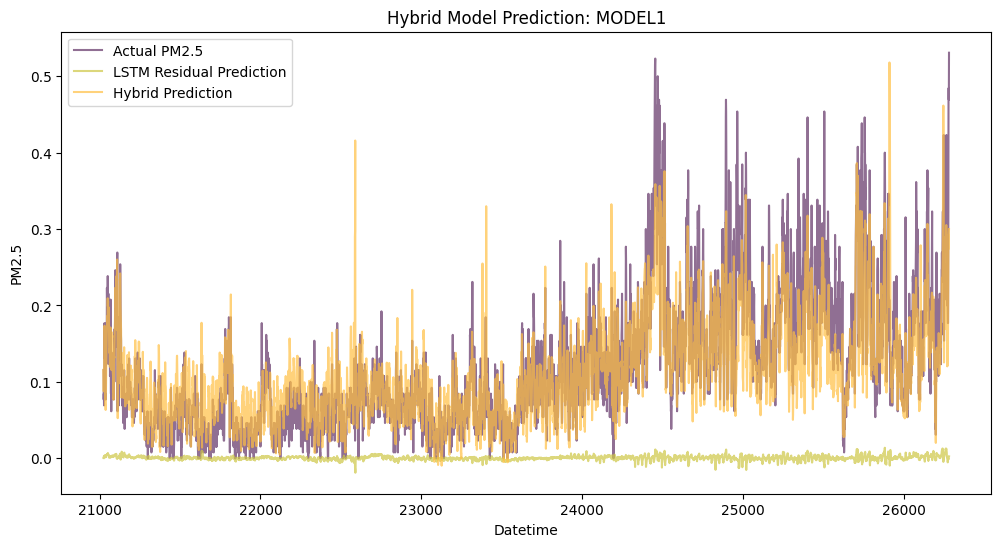

In [ ]:

# 處理實際值
actual_values = test_tainan_endog['PM2.5'].values.flatten()[1:]

# 處理 SARIMAX 預測值
SARIMAX_pred = forecast.values.flatten()[1:] if isinstance(forecast, pd.Series) else forecast.flatten()[1:]

# 處理 LSTM 預測值
lstm_pred = lstm_pred_rescaled.flatten()

# 計算最終預測
final_forecast = SARIMAX_pred + lstm_pred

# 建立結果資料框
final_result = pd.DataFrame({
    'Actual_PM2.5': actual_values,
    'SARIMAX_Prediction': SARIMAX_pred,
    'LSTM_Residual_Prediction': lstm_pred,
    'Final_Prediction': final_forecast
}, index=test_tainan_endog.index[1:])

# 繪製結果
plt.figure(figsize=(12,6))
plt.plot(final_result.index, final_result['Actual_PM2.5'], label='Actual PM2.5', color='#906f93')
plt.plot(final_result.index, final_result['LSTM_Residual_Prediction'], label='LSTM Residual Prediction', color='#cec745', alpha=0.7)
plt.plot(final_result.index, final_result['Final_Prediction'], label='Hybrid Prediction', color='#ffc043', alpha=0.7)
plt.title('Hybrid Model Prediction: MODEL1')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.legend()

plt.show()

In [194]:
# 使用縮放後的資料
train_scaled_LSTM = scaled_tainan_2021_23.iloc[:train_size]
test_scaled_LSTM = scaled_tainan_2021_23.iloc[train_size:]

# 準備 LSTM 的輸入和輸出
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 使用殘差作為目標變數，特徵變數為縮放後的數據
X_train, y_train = create_dataset(
    train_scaled_LSTM[['O3', 'SO2', 'CH4', 'NO', 'PM10']].values,
    train_scaled_LSTM[['PM2.5']].values,
    time_steps=1
)

X_test, y_test = create_dataset(
    test_scaled_LSTM[['O3', 'SO2', 'CH4', 'NO', 'PM10']].values,
    test_scaled_LSTM[['PM2.5']].values,
    time_steps=1
)


In [195]:
# 建立 LSTM 模型
model_lstm_2 = Sequential()
model_lstm_2.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm_2.add(Dense(1))
model_lstm_2.compile(loss='mean_squared_error', optimizer='adam')

# 訓練模型
model_lstm_2.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)


/Users/lee/miniforge3/envs/ML_py39/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
292/292 - 2s - 5ms/step - loss: 0.0121 - val_loss: 0.0059
Epoch 2/50
292/292 - 0s - 1ms/step - loss: 0.0068 - val_loss: 0.0042
Epoch 3/50
292/292 - 0s - 1ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 4/50
292/292 - 0s - 1ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 5/50
292/292 - 0s - 1ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 6/50
292/292 - 0s - 1ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 7/50
292/292 - 1s - 2ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 8/50
292/292 - 0s - 1ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 9/50
292/292 - 0s - 1ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 10/50
292/292 - 0s - 1ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 11/50
292/292 - 0s - 1ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 12/50
292/292 - 0s - 1ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 13/50
292/292 - 0s - 1ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 14/50
292/292 - 0s - 1ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 15/50
292/292 - 0s - 99

In [196]:
y_test_pred = model_lstm_2.predict(X_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [197]:
y_test_pred

array([[0.06136104],
       [0.10255928],
       [0.07514901],
       ...,
       [0.27751648],
       [0.2654348 ],
       [0.28322506]], dtype=float32)

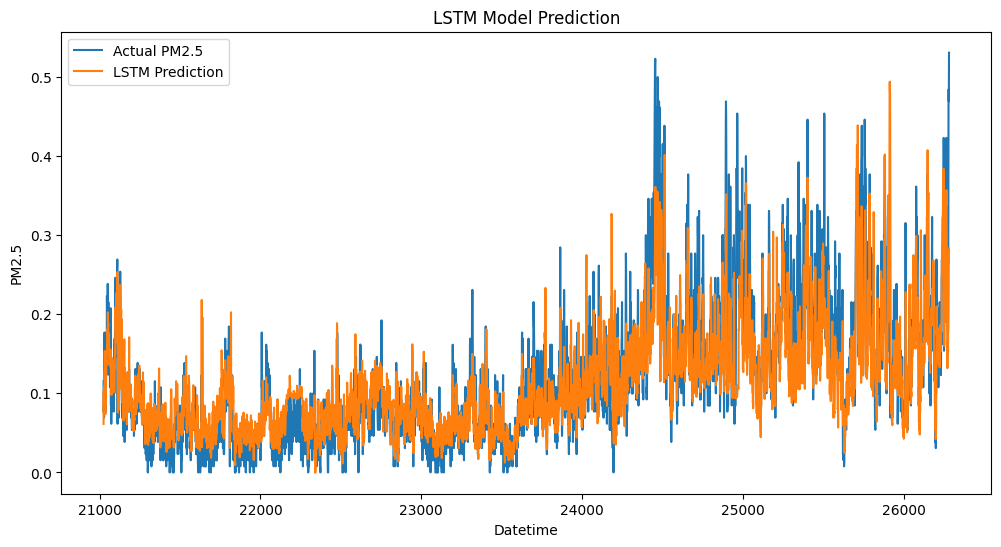

In [199]:
# 將預測結果與實際值進行比較
plt.figure(figsize=(12,6))
plt.plot(final_result.index, y_test, label='Actual PM2.5')
plt.plot(final_result.index, y_test_pred, label='LSTM Prediction')
plt.title('LSTM Model Prediction')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

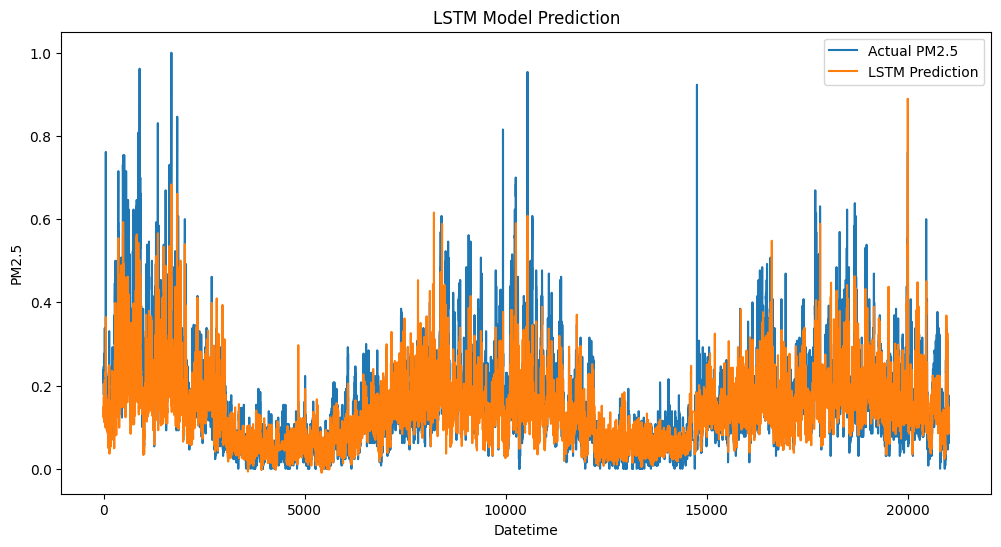

In [202]:
# 將預測結果與實際值進行比較
plt.figure(figsize=(12,6))
plt.plot(train_scaled_LSTM.index[1:], y_train, label='Actual PM2.5')
plt.plot(train_scaled_LSTM.index[1:], train_pred_LSTM, label='LSTM Prediction')
plt.title('LSTM Model Prediction')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [201]:
# 訓練集殘差
train_pred_LSTM = model_lstm_2.predict(X_train)
train_tainan_residuals_LSTM = y_train - train_pred_LSTM

657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step


In [203]:
test_tainan_residuals_LSTM = y_test - y_test_pred

In [211]:

model_res_SAR = SARIMAX(train_tainan_residuals_LSTM, 
                exog=train_tainan_exog[1:],
                order=(1,1,1),            
                seasonal_order=(0,1,1,24))

model_res_result = model_res_SAR.fit(disp=False)


print(model_res_result.summary())

/Users/lee/miniforge3/envs/ML_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                21023
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood               39771.316
Date:                            Mon, 06 Jan 2025   AIC                         -79524.632
Time:                                    10:36:57   BIC                         -79453.063
Sample:                                         0   HQIC                        -79501.272
                                          - 21023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
O3             0.0273      0.005      6.019      0.000       0.018       0.036
SO2            0.1257      0.008   

In [205]:
# 進行預測
forecast_res = model_res_result.forecast(steps=len(test_tainan_residuals_LSTM), exog=test_tainan_exog[1:])



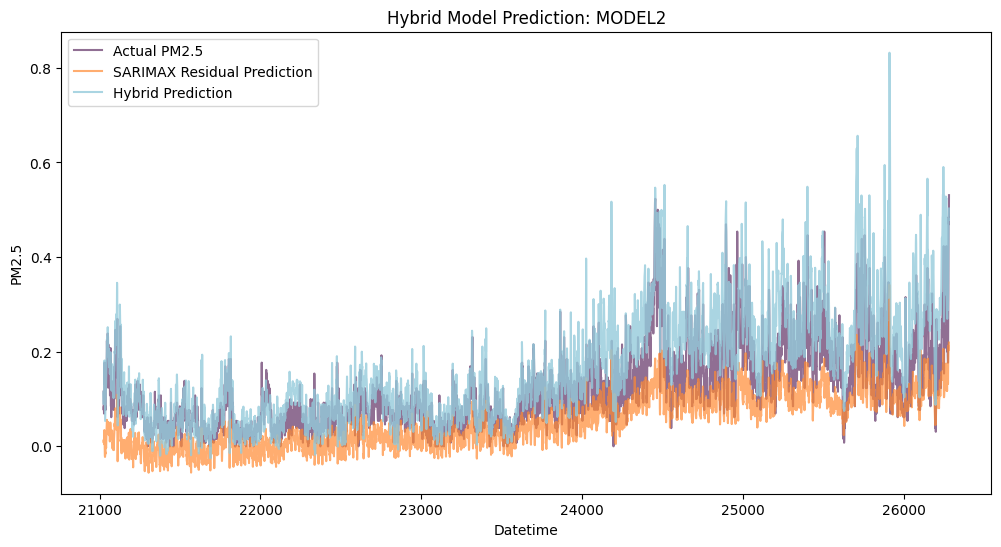

In [ ]:

actual_values = test_tainan_endog['PM2.5'].values.flatten()[1:]

y_test_pred_2 = y_test_pred.flatten()

final_forecast_2 = forecast_res + y_test_pred_2

final_result = pd.DataFrame({
    'Actual_PM2.5': y_test.flatten(),
    'SAR_Residual_Prediction': forecast_res,
    'LSTM_Prediction': y_test_pred_2,
    'Final_Prediction_2': final_forecast_2
}, index=test_tainan_endog.index[1:])

plt.figure(figsize=(12,6))
plt.plot(final_result.index, final_result['Actual_PM2.5'], label='Actual PM2.5', color='#906f93')
plt.plot(final_result.index, final_result['SAR_Residual_Prediction'], label='SARIMAX Residual Prediction', color='#ff8a33', alpha=0.7)
plt.plot(final_result.index, final_result['Final_Prediction_2'], label='Hybrid Prediction', color='#95cbdb', alpha=0.8)
plt.title('Hybrid Model Prediction: MODEL2')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.legend()

plt.show()

In [183]:


mse_sarimax = mean_squared_error(actual_values, SARIMAX_pred)
rmse_sarimax = np.sqrt(mse_sarimax)
mae_sarimax = mean_absolute_error(actual_values, SARIMAX_pred)
r2_sarimax = r2_score(actual_values, SARIMAX_pred)

print('SARIMAX Model:')
print(f'MSE: {mse_sarimax}')
print(f'RMSE: {rmse_sarimax}')
print(f'MAE: {mae_sarimax}')
print(f'R2 Score: {r2_sarimax}')



SARIMAX Model:
MSE: 0.0022958550764461466
RMSE: 0.04791508193091343
MAE: 0.03528875163873354
R2 Score: 0.6933400739080537


In [188]:
mse_sarimax_LSTM = mean_squared_error(actual_values, final_forecast)
rmse_sarimax_LSTM = np.sqrt(mse_sarimax_LSTM)
mae_sarimax_LSTM = mean_absolute_error(actual_values, final_forecast)
r2_sarimax_LSTM = r2_score(actual_values, final_forecast)

print('SARIMAX + LSTM Model:')
print(f'MSE: {mse_sarimax_LSTM}')
print(f'RMSE: {rmse_sarimax_LSTM}')
print(f'MAE: {mae_sarimax_LSTM}')
print(f'R2 Score: {r2_sarimax_LSTM}')


SARIMAX + LSTM Model:
MSE: 0.0022651063196226055
RMSE: 0.04759313311416475
MAE: 0.034975736006919333
R2 Score: 0.6974472196907582


In [231]:
mse_LSTM = mean_squared_error(actual_values, y_test_pred)
rmse_LSTM = np.sqrt(mse_LSTM)
mae_LSTM = mean_absolute_error(actual_values, y_test_pred)
r2_LSTM = r2_score(actual_values, y_test_pred)

print('LSTM Model:')
print(f'MSE: {mse_LSTM}')
print(f'RMSE: {rmse_LSTM}')
print(f'MAE: {mae_LSTM}')
print(f'R2 Score: {r2_LSTM}')


LSTM Model:
MSE: 0.0022665367592856894
RMSE: 0.04760815853701642
MAE: 0.03297310017608256
R2 Score: 0.697256154267744


In [209]:
mse_LSTM_SAR = mean_squared_error(actual_values, final_forecast_2)
rmse_LSTM_SAR = np.sqrt(mse_LSTM_SAR)
mae_LSTM_SAR = mean_absolute_error(actual_values, final_forecast_2)
r2_LSTM_SAR = r2_score(actual_values, final_forecast_2)

print('LSTM + SARIMAX Model:')
print(f'MSE: {mse_LSTM_SAR}')
print(f'RMSE: {rmse_LSTM_SAR}')
print(f'MAE: {mae_LSTM_SAR}')
print(f'R2 Score: {r2_LSTM_SAR}')


LSTM + SARIMAX Model:
MSE: 0.005127930892807367
RMSE: 0.07160957263388301
MAE: 0.05256850791747049
R2 Score: 0.31505654484641765
